Found 176 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 39 images belonging to 2 classes.
Train class distribution: [ 68 108]
Validation class distribution: [15 23]
Test class distribution: [15 24]
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 151s 27s/step - accuracy: 0.4884 - loss: 1.0529 - val_accuracy: 0.4737 - val_loss: 0.7294 - learning_rate: 1.0000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 145s 24s/step - accuracy: 0.5198 - loss: 1.0493 - val_accuracy: 0.6579 - val_loss: 0.6354 - learning_rate: 1.0000e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 160s 30s/step - accuracy: 0.6198 - loss: 0.8536 - val_accuracy: 0.6316 - val_loss: 0.6115 - learning_rate: 1.0000e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 144s 24s/step - accuracy: 0.6876 - loss: 0.6957 - val_accuracy: 0.6842 - val_loss: 0.6063 - learning_rate: 1.0000e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 146s 25s/step - accuracy: 0.6553 - loss: 0.8025 - val_accuracy: 0.6842 - val_loss: 0.5936 - learning_rate: 1.0000e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 146s 24s/step - accuracy: 0.6426 - loss: 0.7621 - val_accuracy: 0.6842 - val_loss: 0.5804 - learning_rate: 1.0000e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 143s 24s/step - accuracy: 0.6927 - loss:

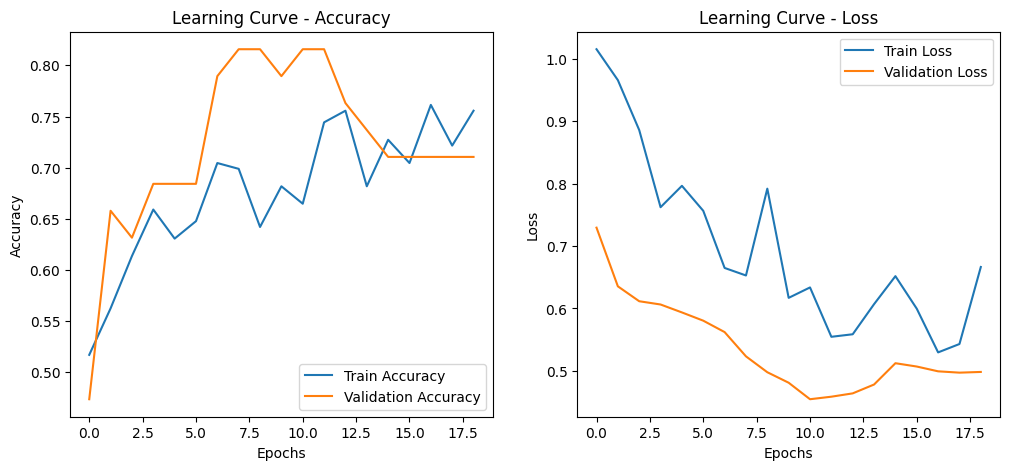

2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.8558 - loss: 0.4167
Test Accuracy: 84.62%


In [ ]:
import numpy as np
import os
import shutil
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import random

# Seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Image dimensions and training parameters
IMG_SIZE = (224, 224)  # Changed image size to 224x224
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 1  # Binary classification: tumor (YES) or no tumor (NO)

# Dataset paths
DATASET_PATH = "./brain_tumor_dataset"
CROPPED_DATASET_PATH = "./cropped_dataset"
TRAIN_PATH = "./TRAIN"
VAL_PATH = "./VAL"
TEST_PATH = "./TEST"

# Function to crop brain images automatically
def crop_brain(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    x, y, w, h = cv2.boundingRect(thresh)
    cropped = image[y:y+h, x:x+w]
    resized = cv2.resize(cropped, IMG_SIZE)
    return resized

# Prepare cropped dataset
if os.path.exists(CROPPED_DATASET_PATH):
    shutil.rmtree(CROPPED_DATASET_PATH)
os.makedirs(CROPPED_DATASET_PATH, exist_ok=True)

for category in os.listdir(DATASET_PATH):
    if category.startswith("."): continue
    os.makedirs(os.path.join(CROPPED_DATASET_PATH, category), exist_ok=True)
    for img_file in os.listdir(os.path.join(DATASET_PATH, category)):
        if img_file.startswith("."): continue
        src_path = os.path.join(DATASET_PATH, category, img_file)
        cropped_img = crop_brain(src_path)
        save_path = os.path.join(CROPPED_DATASET_PATH, category, img_file)
        cv2.imwrite(save_path, cropped_img)

# Clean and recreate folders to avoid mixing old data
def prepare_folders():
    for folder in [TRAIN_PATH, VAL_PATH, TEST_PATH]:
        if os.path.exists(folder):
            shutil.rmtree(folder)
        os.makedirs(folder, exist_ok=True)
        for label in ["YES", "NO"]:
            os.makedirs(os.path.join(folder, label), exist_ok=True)

prepare_folders()

# Stratified Split for Train (70%), Validation (15%), Test (15%)
all_data = {"YES": [], "NO": []}
for category in os.listdir(CROPPED_DATASET_PATH):
    if category.startswith("."): continue
    img_files = [f for f in os.listdir(os.path.join(CROPPED_DATASET_PATH, category)) if not f.startswith('.')]
    all_data[category].extend(img_files)

for category in ["YES", "NO"]:
    np.random.shuffle(all_data[category])
    total = len(all_data[category])
    split1 = int(0.7 * total)
    split2 = int(0.85 * total)

    for i, file in enumerate(all_data[category]):
        src_path = os.path.join(CROPPED_DATASET_PATH, category, file)
        if i < split1:
            dst_path = os.path.join(TRAIN_PATH, category, file)
        elif i < split2:
            dst_path = os.path.join(VAL_PATH, category, file)
        else:
            dst_path = os.path.join(TEST_PATH, category, file)
        shutil.copy(src_path, dst_path)

# Data Augmentation for training to reduce overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', seed=SEED
)
val_generator = val_test_datagen.flow_from_directory(
    VAL_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', seed=SEED
)
test_generator = val_test_datagen.flow_from_directory(
    TEST_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', seed=SEED
)

print("Train class distribution:", np.bincount(train_generator.classes))
print("Validation class distribution:", np.bincount(val_generator.classes))
print("Test class distribution:", np.bincount(test_generator.classes))

# Balance the classes (YES / NO tumors) using class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Load pre-trained VGG19 model without the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1)
]

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve - Loss')
plt.show()

loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")
